In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, recall_score, roc_curve, auc
from imblearn.pipeline import Pipeline
# Estimator
import xgboost as xgb

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# CODE PERSO
import mbr_kernel as mkn
from outils_classification_810 import compute_F2, compute_F2_custom, matrice_de_confusion_binaire
import outils_grid_search_810 as gs810
import outils_mlflow_810 as ml810


NOM_MODELE_BASE='XGBoost'

TEST_SIZE = 0.2
RANDOM_STATE = 42
GIT_FOLDER = './'
INPUT_FOLDER = GIT_FOLDER + 'input_data/'
TMP_FOLDER = GIT_FOLDER+'tmp/'

In [2]:
# ---------------------------------------------------------------- MAKE SCRORER
F2_score = make_scorer(compute_F2, greater_is_better=True)
F2custom_score = make_scorer(compute_F2_custom, greater_is_better=True)

In [13]:
def transform_X(X):
    """Applique les transformation qui precede l'estimator dans le Pipeline. Permet d'obtenir une version des donnees telle que l'estimator traitera"""
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    X_imp = imputer.fit_transform(X)
    X_sc = scaler.fit_transform(X_imp)
    new_X=pd.DataFrame(X_sc, columns=X.columns.tolist())
    return  new_X


def test_model(data, estimator, confusion=False, over_sampling=0.1, under_sampling=0.5, do_under=True) :
    """Permet de tester un model, sans enregistrer les resultats dans MLFlow"""
    print("PREPARING MODEL")
    X = data.drop(columns = ['SK_ID_CURR', 'TARGET'])
    y = data['TARGET']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
    print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    over = SMOTE(sampling_strategy=over_sampling, random_state=RANDOM_STATE)
    if do_under :
        under = RandomUnderSampler(sampling_strategy=under_sampling, random_state=RANDOM_STATE)
    estimator = estimator

    if do_under :
        be = Pipeline([
            ("imputer", imputer),
            ("scaler", scaler),
            ("over", over),
            ("under", under),
            ("estimator", estimator)
        ])
    else :
        be = Pipeline([
            ("imputer", imputer),
            ("scaler", scaler),
            ("over", over),
            ("estimator", estimator)
        ])

    be.fit(X_train, y_train)

    print("TESTING MODEL")
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = compute_F2(y_true=y_train, y_pred=y_train_pred)
    train_F2c_score = compute_F2_custom(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print("TRAIN F2 score", train_F2_score)
    print("TRAIN F2Custom score", train_F2c_score)
    print("TRAIN AUC", train_auc_score)
    print("TRAIN Recall", train_rappel)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = compute_F2(y_true=y_test, y_pred=y_pred)
    test_F2c_score = compute_F2_custom(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("TEST F2 score", test_F2_score)
    print("TEST F2Custom score", test_F2c_score)
    print("TEST AUC", test_auc_score)
    print("TEST Recall", test_rappel)

    if confusion :
        matrice_de_confusion_binaire(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=TMP_FOLDER, nomfichier="model_Test_cm.png")
    return {'model' : be, 'test_F2' : test_F2_score, 'test_aux' : test_auc_score, 'test_rappel' : test_rappel}


# PREPROCESS DATA

In [4]:
df_train = pd.read_csv('./input_data/application_train.csv')
df = mkn.full_feature_engineering(df_input=df_train, df_folder='./input_data/',encoding_treshold=0.04, nan_treshold=0.4)
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Forme initiale du Dataframe :  (307511, 122)


/home/maximorose/git_repositories/cln_oc_p07/outils_feature_engineering_810.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)
/home/maximorose/git_repositories/cln_oc_p07/mbr_kernel.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
/home/maximorose/git_repositories/cln_oc_p07/mbr_kernel.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Forme du Dataframe apres traitement :  (219656, 122)

Application dataframe shape:  (219656, 14)
application processing - done in 1s
Forme initiale du Dataframe :  (1716428, 17)
Forme du Dataframe apres traitement :  (1716428, 17)
Bureau dataframe shape:  (305811, 8)
Bureau and bureau_balance processing - done in 8s
Forme initiale du Dataframe :  (1670214, 37)


/home/maximorose/git_repositories/cln_oc_p07/outils_feature_engineering_810.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)


Forme du Dataframe apres traitement :  (1234578, 37)
Forme initiale du Dataframe :  (13605401, 8)
Forme du Dataframe apres traitement :  (13605401, 8)
Previous Application dataframe shape:  (338308, 12)
Previous application processing - done in 22s
Pos-Cash dataframe shape:  (337252, 3)
Pos-Cash processing - done in 5s
Installement dataframe shape:  (339587, 7)
Installment processing - done in 12s
CC dataframe shape:  (103558, 6)
CC processing - done in 6s
X_train : (175724, 48) // X_test : (43932, 48)
y_train : (175724,) // y_test : (43932,)


# GRIDSEARCH

In [5]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = xgb.XGBClassifier(gamma=0.1, learning_rate=0.05)

pipeline = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

params = {
    'estimator__max_depth' : [3, 4, 5],
    'estimator__min_child_weight' : [200, 300, 400],
    'estimator__colsample_bytree': [0.2, 0.3, 0.4],
    'estimator__subsample': [0.2, 0.3, 0.4],
    'estimator__n_estimators': [400, 500, 600],
    'estimator__scale_pos_weight': [2, 4, 6]
}

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=F2_score,
    return_train_score=True,
    verbose=2,
    n_jobs=-1
)

model.fit(X_train, y_train)

model

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END estimator__colsample_bytree=0.2, estimator__max_depth=3, estimator__min_child_weight=200, estimator__n_estimators=400, estimator__scale_pos_weight=2, estimator__subsample=0.2; total time=  13.1s
[CV] END estimator__colsample_bytree=0.2, estimator__max_depth=3, estimator__min_child_weight=200, estimator__n_estimators=400, estimator__scale_pos_weight=2, estimator__subsample=0.3; total time=  14.3s
[CV] END estimator__colsample_bytree=0.2, estimator__max_depth=3, estimator__min_child_weight=200, estimator__n_estimators=400, estimator__scale_pos_weight=4, estimator__subsample=0.2; total time=  12.8s
[CV] END estimator__colsample_bytree=0.2, estimator__max_depth=3, estimator__min_child_weight=200, estimator__n_estimators=400, estimator__scale_pos_weight=4, estimator__subsample=0.4; total time=  15.5s
[CV] END estimator__colsample_bytree=0.2, estimator__max_depth=3, estimator__min_child_weight=200, estimator__n_estimato

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        XGBClassifier(base_score=None,
                                                      booster=No...
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'estimator__colsample_bytree': [0.2, 0.3, 0.4],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__min_child_weight': [200, 300, 400],
                         'estimator__n_estimators': [400, 500, 600],
                         'estimator__scale_pos_weight': [2, 4, 6],
                         'estimator__subsample': [0.2, 0.3, 0.4]},
             return_train_score=True, scoring=make_scorer(compute_F2),
             verbose=2)

3h34 pour 3645 fits

24 minutes pour 405 fits de XGBoost

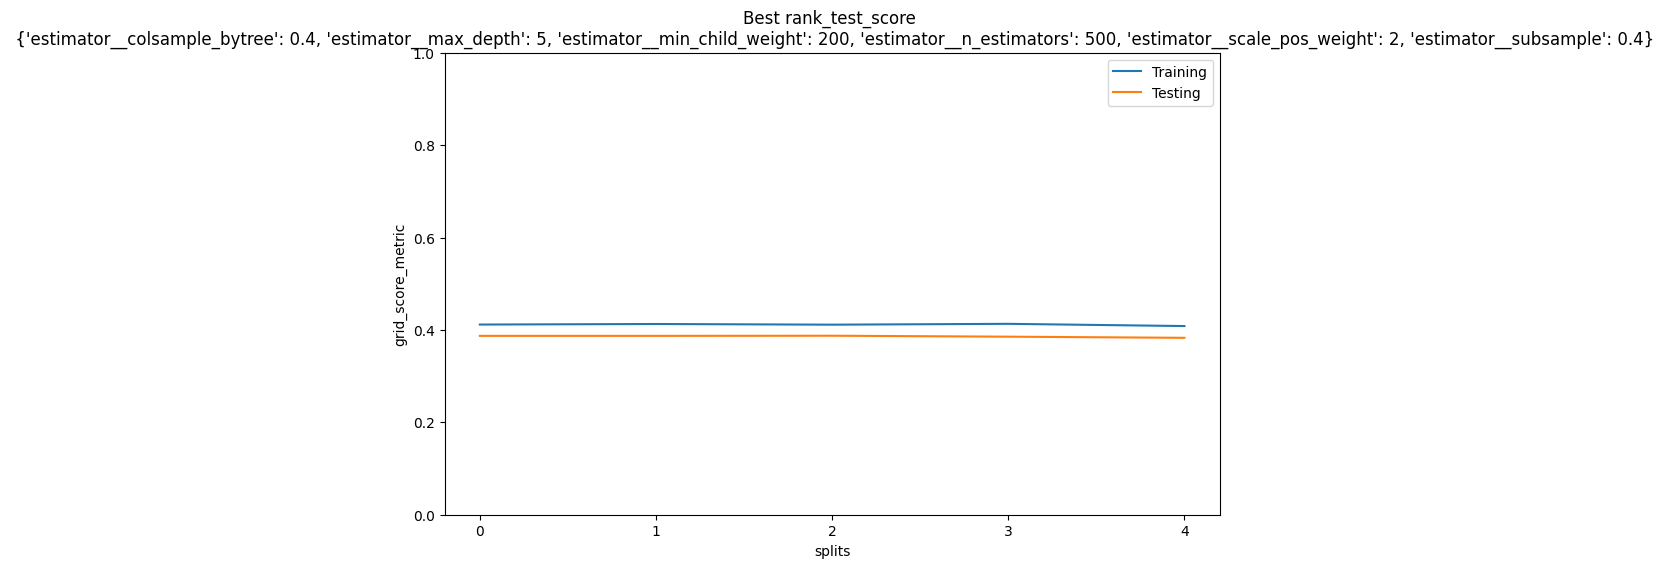

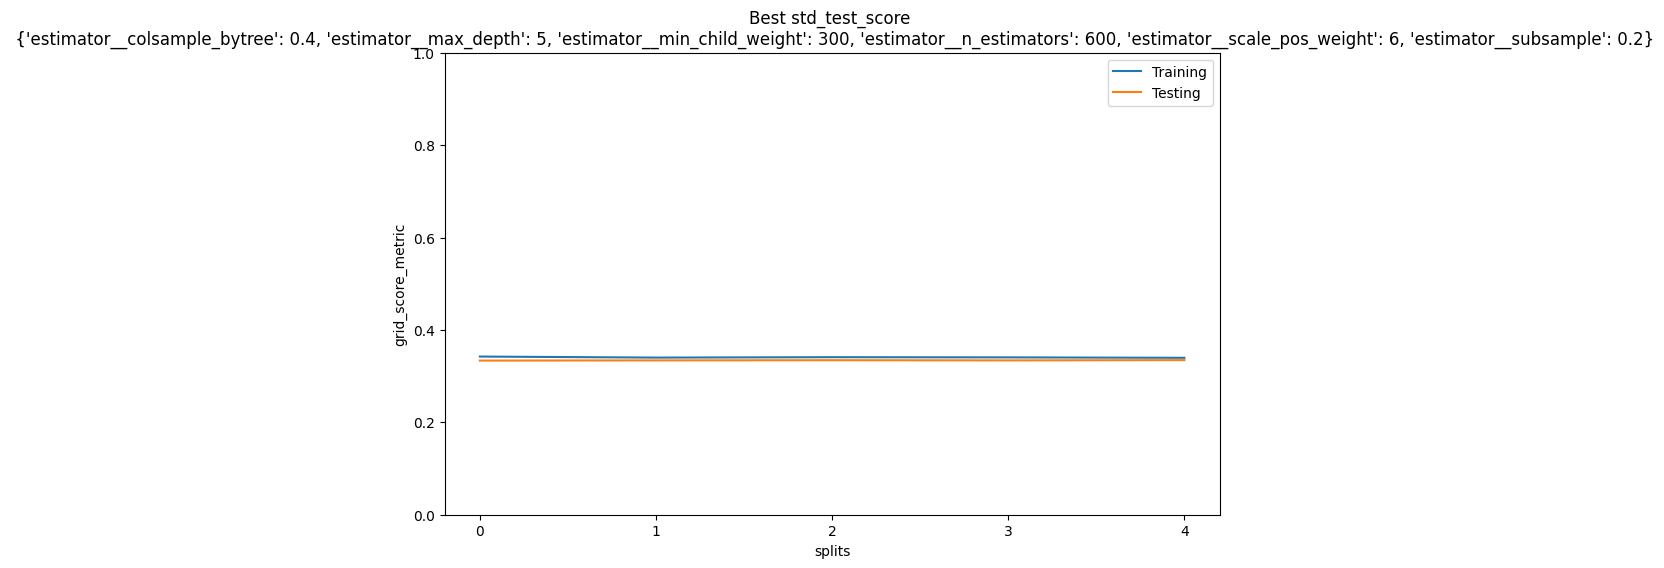

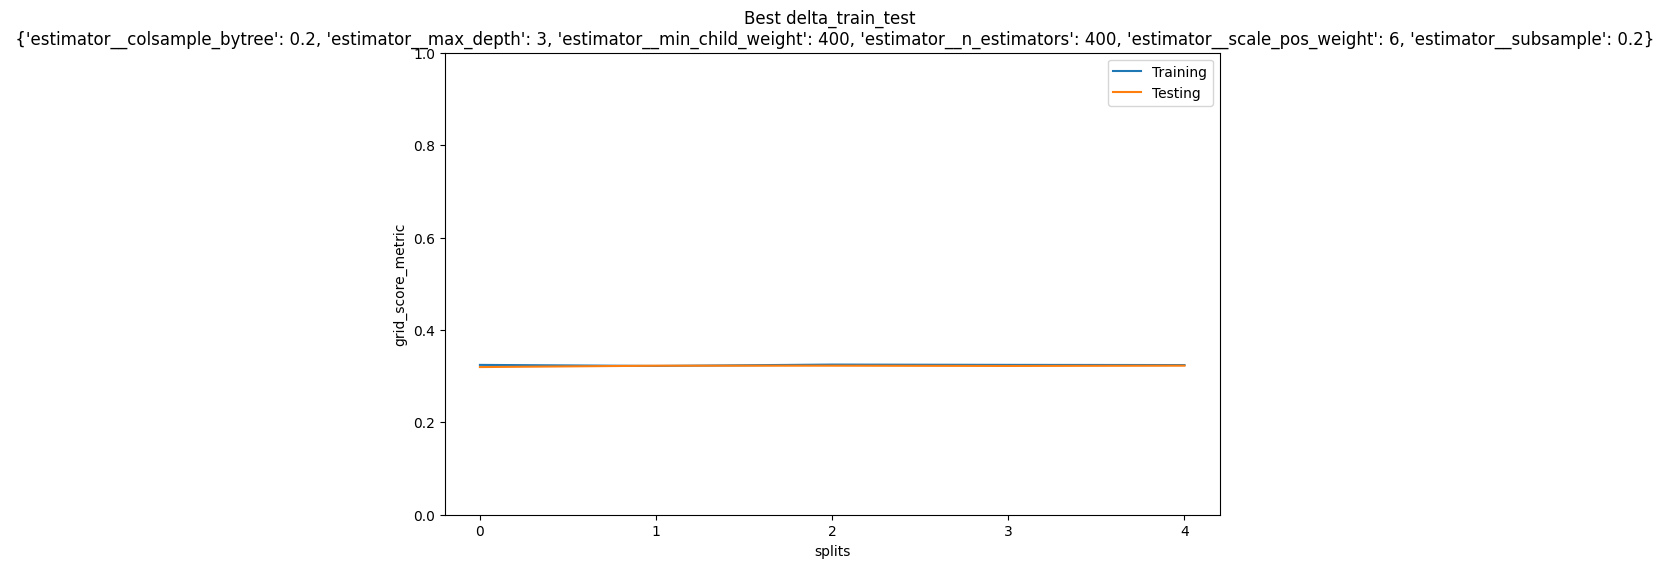

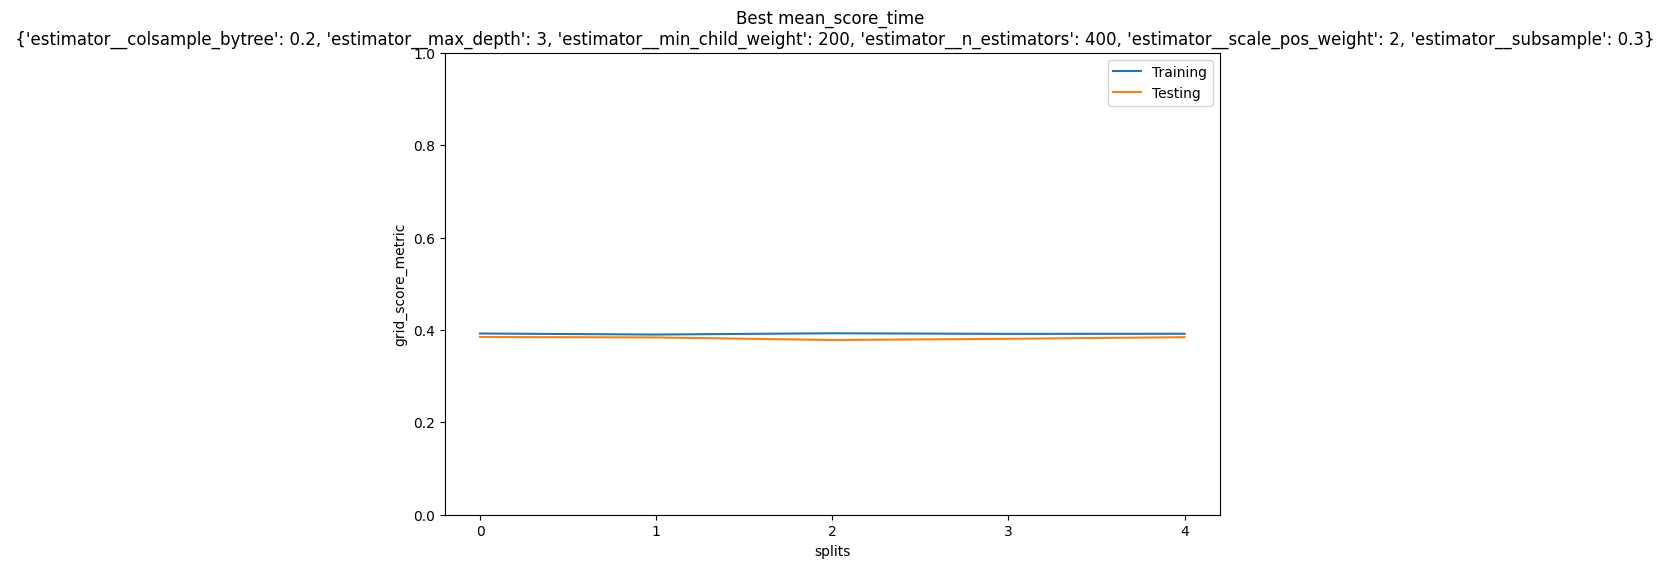

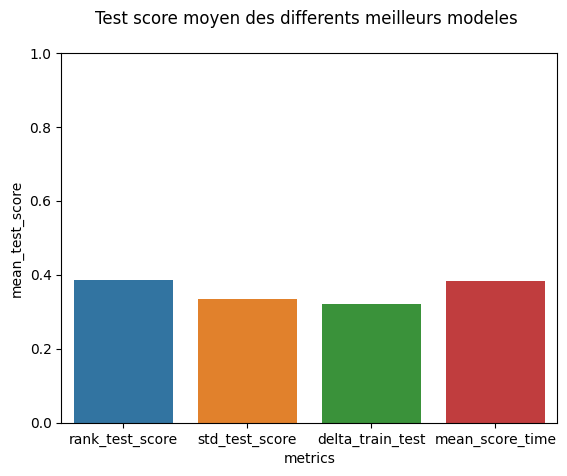

In [6]:
grid_results = gs810.grid_resultification(grid=model)
df_to_plot, df_models = gs810.get_split_scores_for_model(res_grid=grid_results, nb_cv=5)
list_img, path_to_models_csv =gs810.plot_split_scores(df_to_plot, df_models, save=True, path=TMP_FOLDER)

In [7]:
grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__colsample_bytree,param_estimator__max_depth,param_estimator__min_child_weight,param_estimator__n_estimators,param_estimator__scale_pos_weight,param_estimator__subsample,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,delta_train_test
0,13.030346,0.264687,0.302608,0.005101,0.2,3,200,400,2,0.2,...,0.001434,159,0.388781,0.386342,0.388323,0.387229,0.386191,0.387373,0.001036,0.007876
1,13.944442,0.136968,0.272184,0.010370,0.2,3,200,400,2,0.3,...,0.002480,81,0.392251,0.389971,0.392777,0.391421,0.391703,0.391625,0.000949,0.009288
2,15.456814,0.266378,0.293199,0.030003,0.2,3,200,400,2,0.4,...,0.002545,58,0.393377,0.393427,0.394226,0.394103,0.392757,0.393578,0.000535,0.010451
3,12.701976,0.197156,0.294031,0.007740,0.2,3,200,400,4,0.2,...,0.002315,446,0.359057,0.356232,0.358152,0.357555,0.358207,0.357840,0.000936,0.004922
4,14.270785,0.308620,0.282309,0.015259,0.2,3,200,400,4,0.3,...,0.001499,449,0.359297,0.357745,0.358376,0.358976,0.360448,0.358968,0.000910,0.006209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,39.810216,1.020898,0.794109,0.030681,0.4,5,400,600,4,0.3,...,0.002916,306,0.371737,0.368981,0.370671,0.370042,0.370155,0.370317,0.000898,0.011157
725,45.943148,0.841114,0.782436,0.016390,0.4,5,400,600,4,0.4,...,0.003585,251,0.376625,0.374320,0.375304,0.376091,0.376446,0.375757,0.000850,0.013536
726,32.469468,0.712595,0.737968,0.006500,0.4,5,400,600,6,0.2,...,0.000559,652,0.335401,0.333637,0.335464,0.333713,0.333459,0.334335,0.000900,0.004228
727,40.096066,0.976069,0.746188,0.085472,0.4,5,400,600,6,0.3,...,0.001510,530,0.344419,0.342626,0.344388,0.343937,0.342258,0.343526,0.000909,0.007742


mean_score_time / mean_test_score
BEST SCORE MEAN MODEL :
- 0.642343 / 0.385999
BEST MEAN SCORE TIME :
- 0.272184 / 0.382336

In [8]:
print("Best Model Vs. Fastest : ")
print("-----")
print("Perte de score : ", (1 - 0.382336/0.385999))
print("Gain de temps : ", (1 - 0.272184/0.642343))

Best Model Vs. Fastest : 
-----
Perte de score :  0.009489661890315748
Gain de temps :  0.5762637718477511


Le model le plus rapide semble offrir le meilleur compromis precision/temps

In [9]:
df_models

,metrics,best_params,mean_test_score,metric_value
0,rank_test_score,"{'estimator__colsample_bytree': 0.4, 'estimato...",0.385999,1.000000
1,std_test_score,"{'estimator__colsample_bytree': 0.4, 'estimato...",0.334161,0.000379
2,delta_train_test,"{'estimator__colsample_bytree': 0.2, 'estimato...",0.321877,0.002052
3,mean_score_time,"{'estimator__colsample_bytree': 0.2, 'estimato...",0.382336,0.272184


- min_child_weight fonctionne comme pour la random forest : Une valeur elevee permet d'accelerer le processus, mais risque de reduire la precision
- scale_pos_weight est determinant pour compenser notre unbalanced dataset

In [10]:
ml810.save_grid_results(list_of_image=list_img,
                        grid_estimator=NOM_MODELE_BASE,
                        ini_params="gamma=0.1, learning_rate=0.05",
                        path_to_csv=path_to_models_csv)

In [11]:
grid_results.to_csv('./processed_data/grid_xgboost_results_06-15.csv')

# TEST MODEL

{'estimator__colsample_bytree': 0.2, 'estimator__max_depth': 3, 'estimator__min_child_weight': 200, 'estimator__n_estimators': 400, 'estimator__scale_pos_weight': 2, 'estimator__subsample': 0.3}

PREPARING MODEL
X_train : (175724, 48) // X_test : (43932, 48)
y_train : (175724,) // y_test : (43932,)
TESTING MODEL
TRAIN F2 score 0.3920923774026163
TRAIN F2Custom score 0.479087367586815
TRAIN AUC 0.6792783161782552
TRAIN Recall 0.657828186067898
TEST F2 score 0.3737221998314586
TEST F2Custom score 0.4551031790295594
TEST AUC 0.6626424239482235
TEST Recall 0.6253832004904967


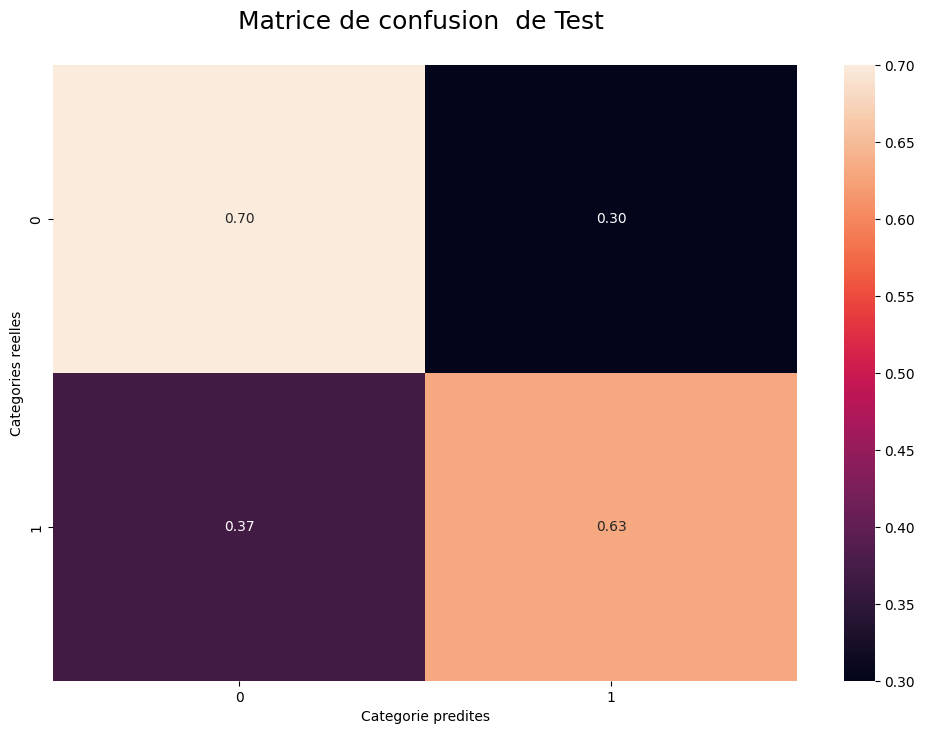

In [14]:
dict_results = test_model(df, xgb.XGBClassifier(gamma=0.1,
                                                max_depth=3,
                                                n_estimators=400,
                                                learning_rate=0.05,
                                                colsample_bytree=0.2,
                                                min_child_weight=200,
                                                scale_pos_weight=2,
                                                subsample=0.3),
                          confusion=True, over_sampling=0.1, under_sampling=0.5, do_under=True)

Il est finalement moins bon que celui que nous avions obtenu precedemment.

# SAVE MODEL

In [13]:
estimator = xgb.XGBClassifier(gamma=0.1,
                            max_depth=3,
                            n_estimators=400,
                            learning_rate=0.05,
                            colsample_bytree=0.2,
                            min_child_weight=200,
                            scale_pos_weight=2,
                            subsample=0.3)

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.2, ea...
                               feature_types=None, gamma=0.1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=200, missing=nan,
                               monotone_constraints=None, n_estimators=400,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

/home/maximorose/anaconda3/envs/oc_ds_p7/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


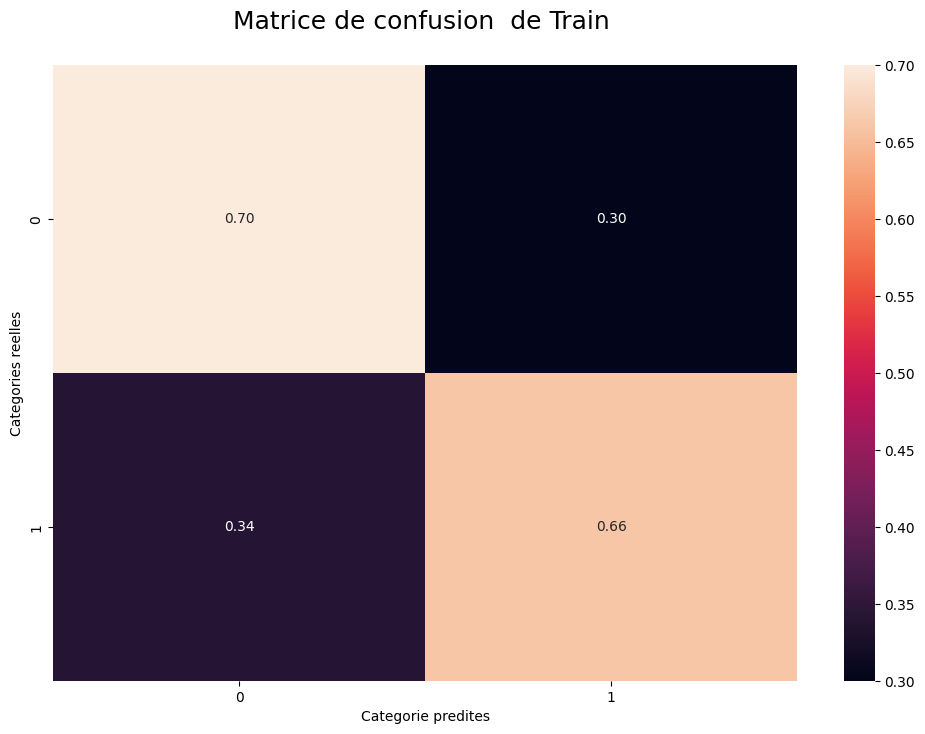

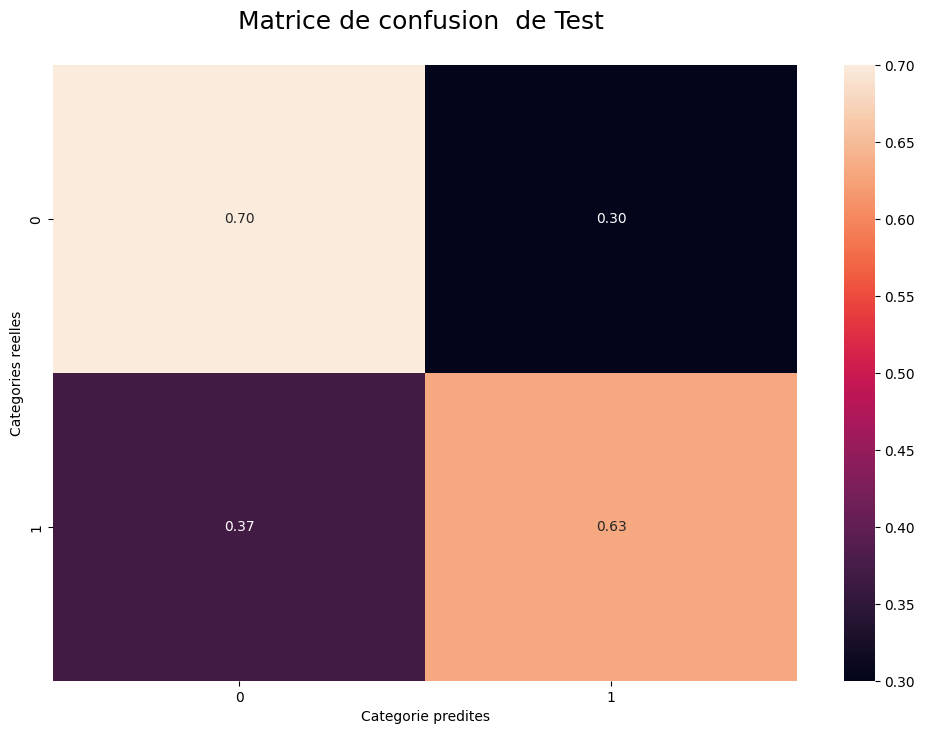

In [14]:
ml810.classification_binaire_save_results(xglob=X, model=model,
                                          xtrain=X_train, ytrain=y_train,
                                          xtest=X_test, ytest=y_test,
                                          nom_model=NOM_MODELE_BASE,
                                          estimator=NOM_MODELE_BASE,
                                          tmp_folder=TMP_FOLDER)